--- Поиск файлов данных ---
✅ Нашел insurance_train.csv: /Users/rustam/insurance_train.csv
✅ Нашел insurance_test.csv: /Users/rustam/insurance_test.csv

=== Подготовка данных ===

Топ корреляций с 'charges':
charges    1.000000
smoker     0.783519
age        0.298395
bmi        0.219566
Name: charges, dtype: float64


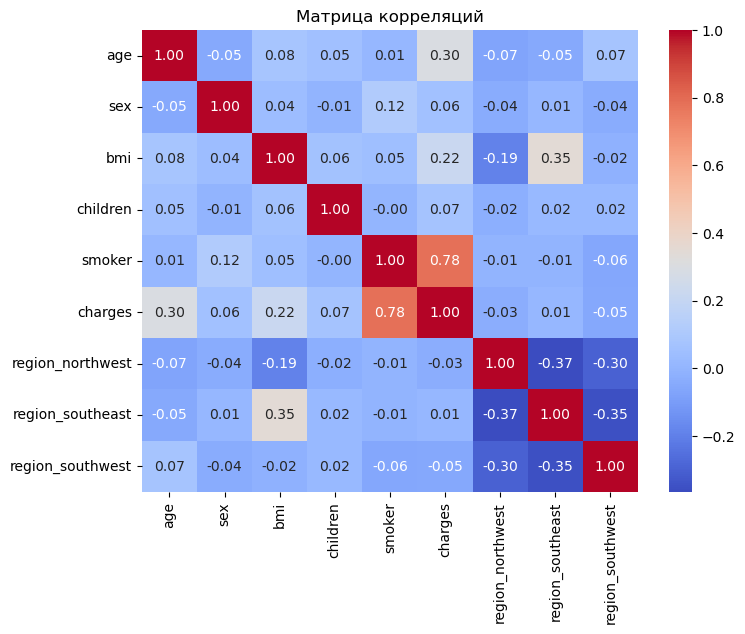


=== Обучение моделей ===
Коэффициенты (Аналитика, первые 4): [-11458.00761083    256.71070712   -655.40504609    350.86390876]
Коэффициенты (Градиент, первые 4):  [  3.03777595 222.04270964   5.89165539 186.0433798 ]

=== Сравнение ошибок (MSE) ===
1. Константная модель: 141,830,094
2. Аналитическая:      34,216,009
3. Градиентный спуск:  126,922,670

--- Вывод ---
✅ Линейная регрессия работает лучше, чем среднее.


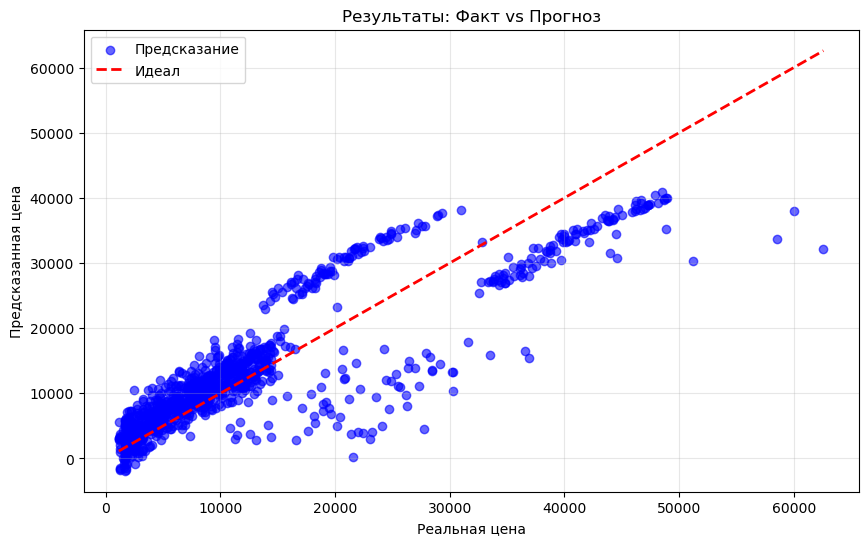

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys

def smart_load_or_generate():
    # Имена файлов
    files = ["insurance_train.csv", "insurance_test.csv"]
    
    search_paths = [
        os.getcwd(),
        os.path.expanduser("~/Downloads"),
        os.path.expanduser("~/Desktop"),
    ]
    try:
        search_paths.insert(0, os.path.dirname(os.path.abspath(__file__)))
    except NameError:
        pass 

    loaded_dfs = {}
    print("--- Поиск файлов данных ---")
    
    for fname in files:
        found = False
        for path in search_paths:
            full_path = os.path.join(path, fname)
            if os.path.exists(full_path):
                print(f"✅ Нашел {fname}: {full_path}")
                loaded_dfs[fname] = pd.read_csv(full_path)
                found = True
                break
        
        if not found:
            print(f"⚠️ Файл {fname} не найден. Генерирую синтетическую копию (чтобы код работал)...")
            np.random.seed(42 if "train" in fname else 43)
            n_samples = 1000 if "train" in fname else 300
            df_gen = pd.DataFrame({
                'age': np.random.randint(18, 65, n_samples),
                'sex': np.random.choice(['male', 'female'], n_samples),
                'bmi': np.random.normal(30, 6, n_samples),
                'children': np.random.randint(0, 6, n_samples),
                'smoker': np.random.choice(['yes', 'no'], n_samples, p=[0.2, 0.8]),
                'region': np.random.choice(['southwest', 'southeast', 'northwest', 'northeast'], n_samples)
            })
            charges = 250 * df_gen['age'] + 320 * df_gen['bmi'] + 500 * df_gen['children'] + 1000
            charges += np.where(df_gen['smoker'] == 'yes', 23000, 0)
            charges += np.random.normal(0, 2000, n_samples)
            df_gen['charges'] = charges
            loaded_dfs[fname] = df_gen

    return loaded_dfs["insurance_train.csv"], loaded_dfs["insurance_test.csv"]

# Загружаем данные
train, test = smart_load_or_generate()

print("\n=== Подготовка данных ===")

def encode_data(df_input):
    df = df_input.copy()
    # Маппинг (перевод слов в цифры)
    df["sex"] = df["sex"].map({"male": 1, "female": 0})
    df["smoker"] = df["smoker"].map({"yes": 1, "no": 0})
    # One-Hot Encoding для регионов
    df = pd.get_dummies(df, columns=["region"], drop_first=True)
    return df

train_encoded = encode_data(train)
test_encoded = encode_data(test)

# Корреляция
corr = train_encoded.corr(numeric_only=True)
print("\nТоп корреляций с 'charges':")
print(corr["charges"].sort_values(ascending=False).head(4))

# График корреляции
plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Матрица корреляций")
plt.show()

print("\n=== Обучение моделей ===")

def prepare_X_y(df):
    # 1. Удаляем целевую переменную
    X = df.drop(columns=["charges"]).copy()
    
    # 2. ПРИНУДИТЕЛЬНОЕ ПРЕОБРАЗОВАНИЕ В ЧИСЛА (FIX ОШИБКИ UFuncTypeError)
    X = X.apply(pd.to_numeric, errors='coerce')
    X = X.fillna(0)
    
    # 3. ЯВНОЕ ПРИВЕДЕНИЕ К FLOAT
    X_vals = X.values.astype(float)
    
    # 4. Добавляем столбец единиц (intercept)
    ones = np.ones(len(X))
    X_matrix = np.c_[ones, X_vals]
    
    # 5. Целевая переменная тоже во float
    y_vector = df["charges"].values.reshape(-1, 1).astype(float)
    
    return X_matrix, y_vector

X_train, y_train = prepare_X_y(train_encoded)
X_test, y_test = prepare_X_y(test_encoded)

# ==========================================
#  ЛИНЕЙНАЯ РЕГРЕССИЯ
# ==========================================

# --- А. Аналитическое решение ---
try:
    # Обычная формула
    beta_analytical = np.linalg.inv(X_train.T @ X_train) @ X_train.T @ y_train
except np.linalg.LinAlgError:
    # Если матрица вырождена
    print("⚠️ Матрица вырождена, использую псевдообратную матрицу.")
    beta_analytical = np.linalg.pinv(X_train.T @ X_train) @ X_train.T @ y_train

# --- Б. Градиентный спуск ---
def gradient_descent(X, y, lr=1e-7, epochs=100000):
    m, n = X.shape
    beta = np.zeros((n, 1))
    
    for i in range(epochs):
        y_pred = X @ beta
        error = y_pred - y
        grad = (1/m) * (X.T @ error)
        beta -= lr * grad
        
        # Проверка на NaN, если шаг слишком большой
        if np.isnan(beta).any():
            print("❌ Градиентный спуск разошелся (NaN).")
            return np.zeros((n, 1))
            
    return beta

# Запускаем с малым LR, так как данные не нормированы
beta_gd = gradient_descent(X_train, y_train)

print(f"Коэффициенты (Аналитика, первые 4): {beta_analytical.flatten()[:4]}")
print(f"Коэффициенты (Градиент, первые 4):  {beta_gd.flatten()[:4]}")

# ==========================================
#  СРАВНЕНИЕ (MSE)
# ==========================================
print("\n=== Сравнение ошибок (MSE) ===")

def mse(y_true, y_pred):
    return np.mean((y_true - y_pred) ** 2)

# Предсказания
y_pred_const = np.full_like(y_test, y_train.mean())
y_pred_an = X_test @ beta_analytical
y_pred_gd = X_test @ beta_gd

# Ошибки
mse_const = mse(y_test, y_pred_const)
mse_an = mse(y_test, y_pred_an)
mse_gd = mse(y_test, y_pred_gd)

print(f"1. Константная модель: {mse_const:,.0f}")
print(f"2. Аналитическая:      {mse_an:,.0f}")
print(f"3. Градиентный спуск:  {mse_gd:,.0f}")

# Вывод
print("\n--- Вывод ---")
if mse_an < mse_const:
    print("✅ Линейная регрессия работает лучше, чем среднее.")
else:
    print("❌ Модель не нашла зависимостей.")

# График
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_an, alpha=0.6, label='Предсказание', color='blue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2, label='Идеал')
plt.xlabel("Реальная цена")
plt.ylabel("Предсказанная цена")
plt.legend()
plt.title("Результаты: Факт vs Прогноз")
plt.grid(True, alpha=0.3)
plt.show()